In [1]:
import os
import sys

sys.path.insert(0, os.path.relpath("../../../../.."))

from recidiviz.calculator.modeling.population_projection.super_simulation.super_simulation_factory import (
    SuperSimulationFactory,
)
from recidiviz.calculator.modeling.population_projection.transition_table import (
    TransitionTable,
)
from recidiviz.calculator.modeling.population_projection.shell_compartment import (
    ShellCompartment,
)
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
from functools import partial
import yaml

In [2]:
%run ../../../../../../recidiviz-research/utils/research_utils.py

In [3]:
adjust_plot_scale(0.4)

In [4]:
policy_sim = SuperSimulationFactory.build_super_simulation(
    "../state/FED/states_reform_act/fed_states_reform_act_model_inputs.yaml"
)

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:00<00:00, 1230.99rows/s]
/Users/justine/.local/share/virtualenvs/pulse-data-xK3VhzVV/lib/python3.8/site-packages/google/cloud/bigquery/table.py:1967: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  df[column] = pandas.Series(df[column], dtype=dtypes[column])


outflows_data returned 288 results


Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 305/305 [00:00<00:00, 1368.23rows/s]


transitions_data returned 305 results


Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 207/207 [00:00<00:00, 833.80rows/s]

total_population_data returned 207 results


In [10]:
# Policy functions

# Simulate policy starting in Jan 2023
policy_ts = 28

remove_drug_trafficking_outflows = partial(
    ShellCompartment.reallocate_outflow,
    reallocation_fraction=1,
    outflow="prison",
    new_outflow="release",
)


def resentence_policy(policy_impact_percent):
    return partial(
        TransitionTable.apply_reductions,
        reduction_df=pd.DataFrame(
            {
                "outflow": "release",
                "affected_fraction": 1,
                "reduction_size": policy_impact_percent / 100,
            },
            index=[0],
        ),
        reduction_type="*",
        retroactive=True,
    )


policy_list = [
    SparkPolicy(
        policy_fn=remove_drug_trafficking_outflows,
        spark_compartment="pretrial",
        sub_population={"crime_type": "100"},
        policy_ts=policy_ts,
        apply_retroactive=False,
    )
] + [
    SparkPolicy(
        policy_fn=resentence_policy(policy_impact_percent),
        spark_compartment="prison",
        sub_population={"crime_type": str(policy_impact_percent)},
        policy_ts=policy_ts,
        apply_retroactive=True,
    )
    for policy_impact_percent in [100, 20, 5]
]

/Users/justine/.local/share/virtualenvs/pulse-data-xK3VhzVV/lib/python3.8/site-packages/pandas/core/indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value


initialization time:  10.080401182174683
initialization time:  7.246516942977905
simulation_time:  8.187530040740967


simulation_time:  8.051424026489258
5846.500000000001


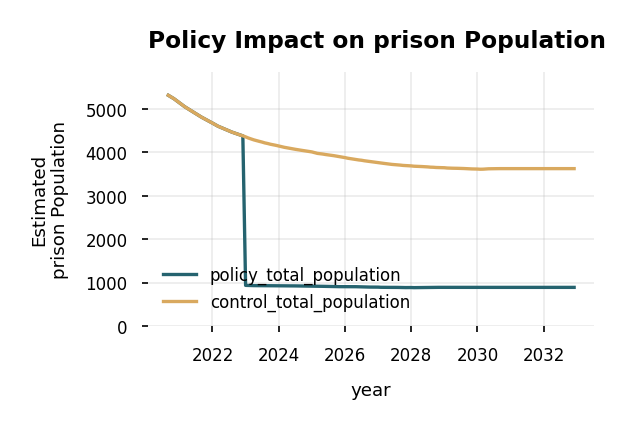

In [11]:
policy_results = policy_sim.simulate_policy(policy_list, "prison")
policy_results["population_difference"] = (
    policy_results["policy_total_population"]
    - policy_results["control_total_population"]
)

In [18]:
simulation_tag = "fed_h5977"
results_dict = policy_sim.upload_policy_simulation_results_to_bq(simulation_tag)

1it [00:02,  2.79s/it]
1it [00:02,  2.61s/it]
1it [00:02,  2.41s/it]
1it [00:05,  5.17s/it]


In [ ]:
policy_results.groupby(["compartment", "year", "simulation_group"]).sum().loc[
    "prison", "population_difference"
].unstack("simulation_group").plot()
add_legend()

<AxesSubplot:xlabel='year'>

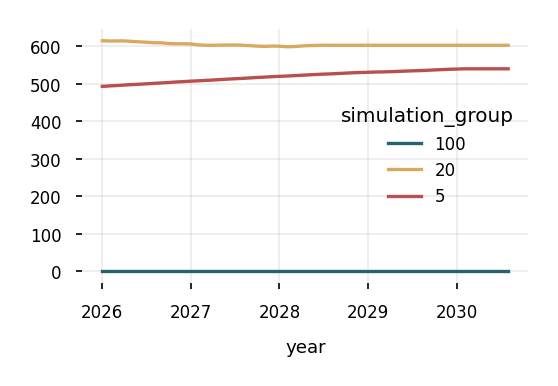

In [117]:
policy_results[policy_results["year"] >= 2026].groupby(
    ["compartment", "year", "simulation_group"]
).sum().loc["prison", "policy_total_population"].unstack("simulation_group").plot()

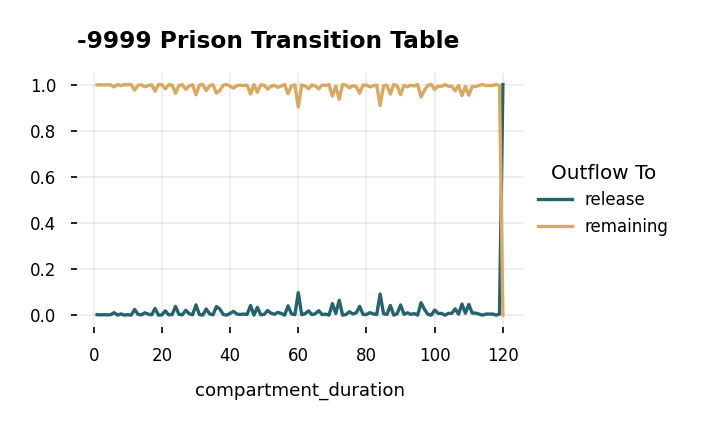

In [57]:
transition_dict = (
    policy_sim.validator.pop_simulations["policy"]
    .sub_simulations["20"]
    .simulation_compartments["prison"]
    .compartment_transitions.transition_tables
)

policy_ts = min(transition_dfs.keys())
for ts, transition_table in transition_dict[policy_ts].tables.items():
    #     if (policy_key != 15) & (transition_type == TransitionTableType.BEFORE):
    #         continue
    transition_table.plot()
    plt.title(f"{ts} Prison Transition Table")
    add_legend(title="Outflow To")

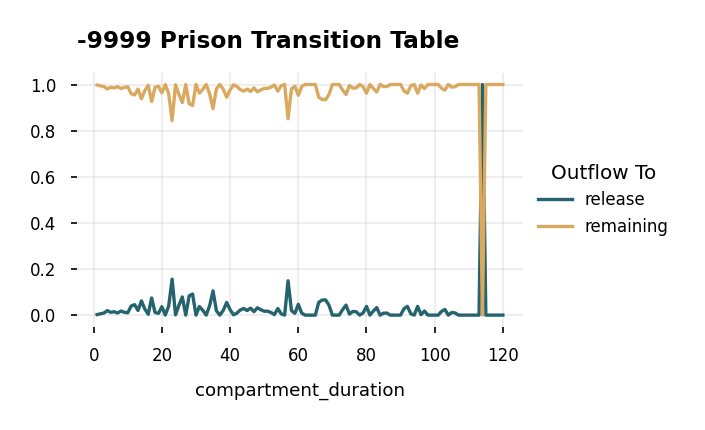

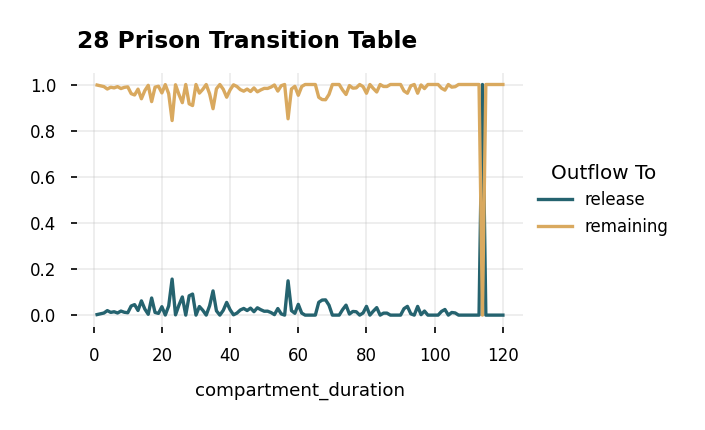

In [60]:
transition_dict = (
    policy_sim.validator.pop_simulations["policy"]
    .sub_simulations["5"]
    .simulation_compartments["prison"]
    .compartment_transitions.transition_tables
)

policy_key = max(transition_dict.keys())
for ts, transition_table in transition_dict[policy_key].tables.items():
    transition_table.plot()
    plt.title(f"{ts} Prison Transition Table")
    add_legend(title="Outflow To")

[<AxesSubplot:title={'left':'simulation_group: 100\ncompartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>,
 <AxesSubplot:title={'left':'simulation_group: 20\ncompartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>,
 <AxesSubplot:title={'left':'simulation_group: 5\ncompartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>]

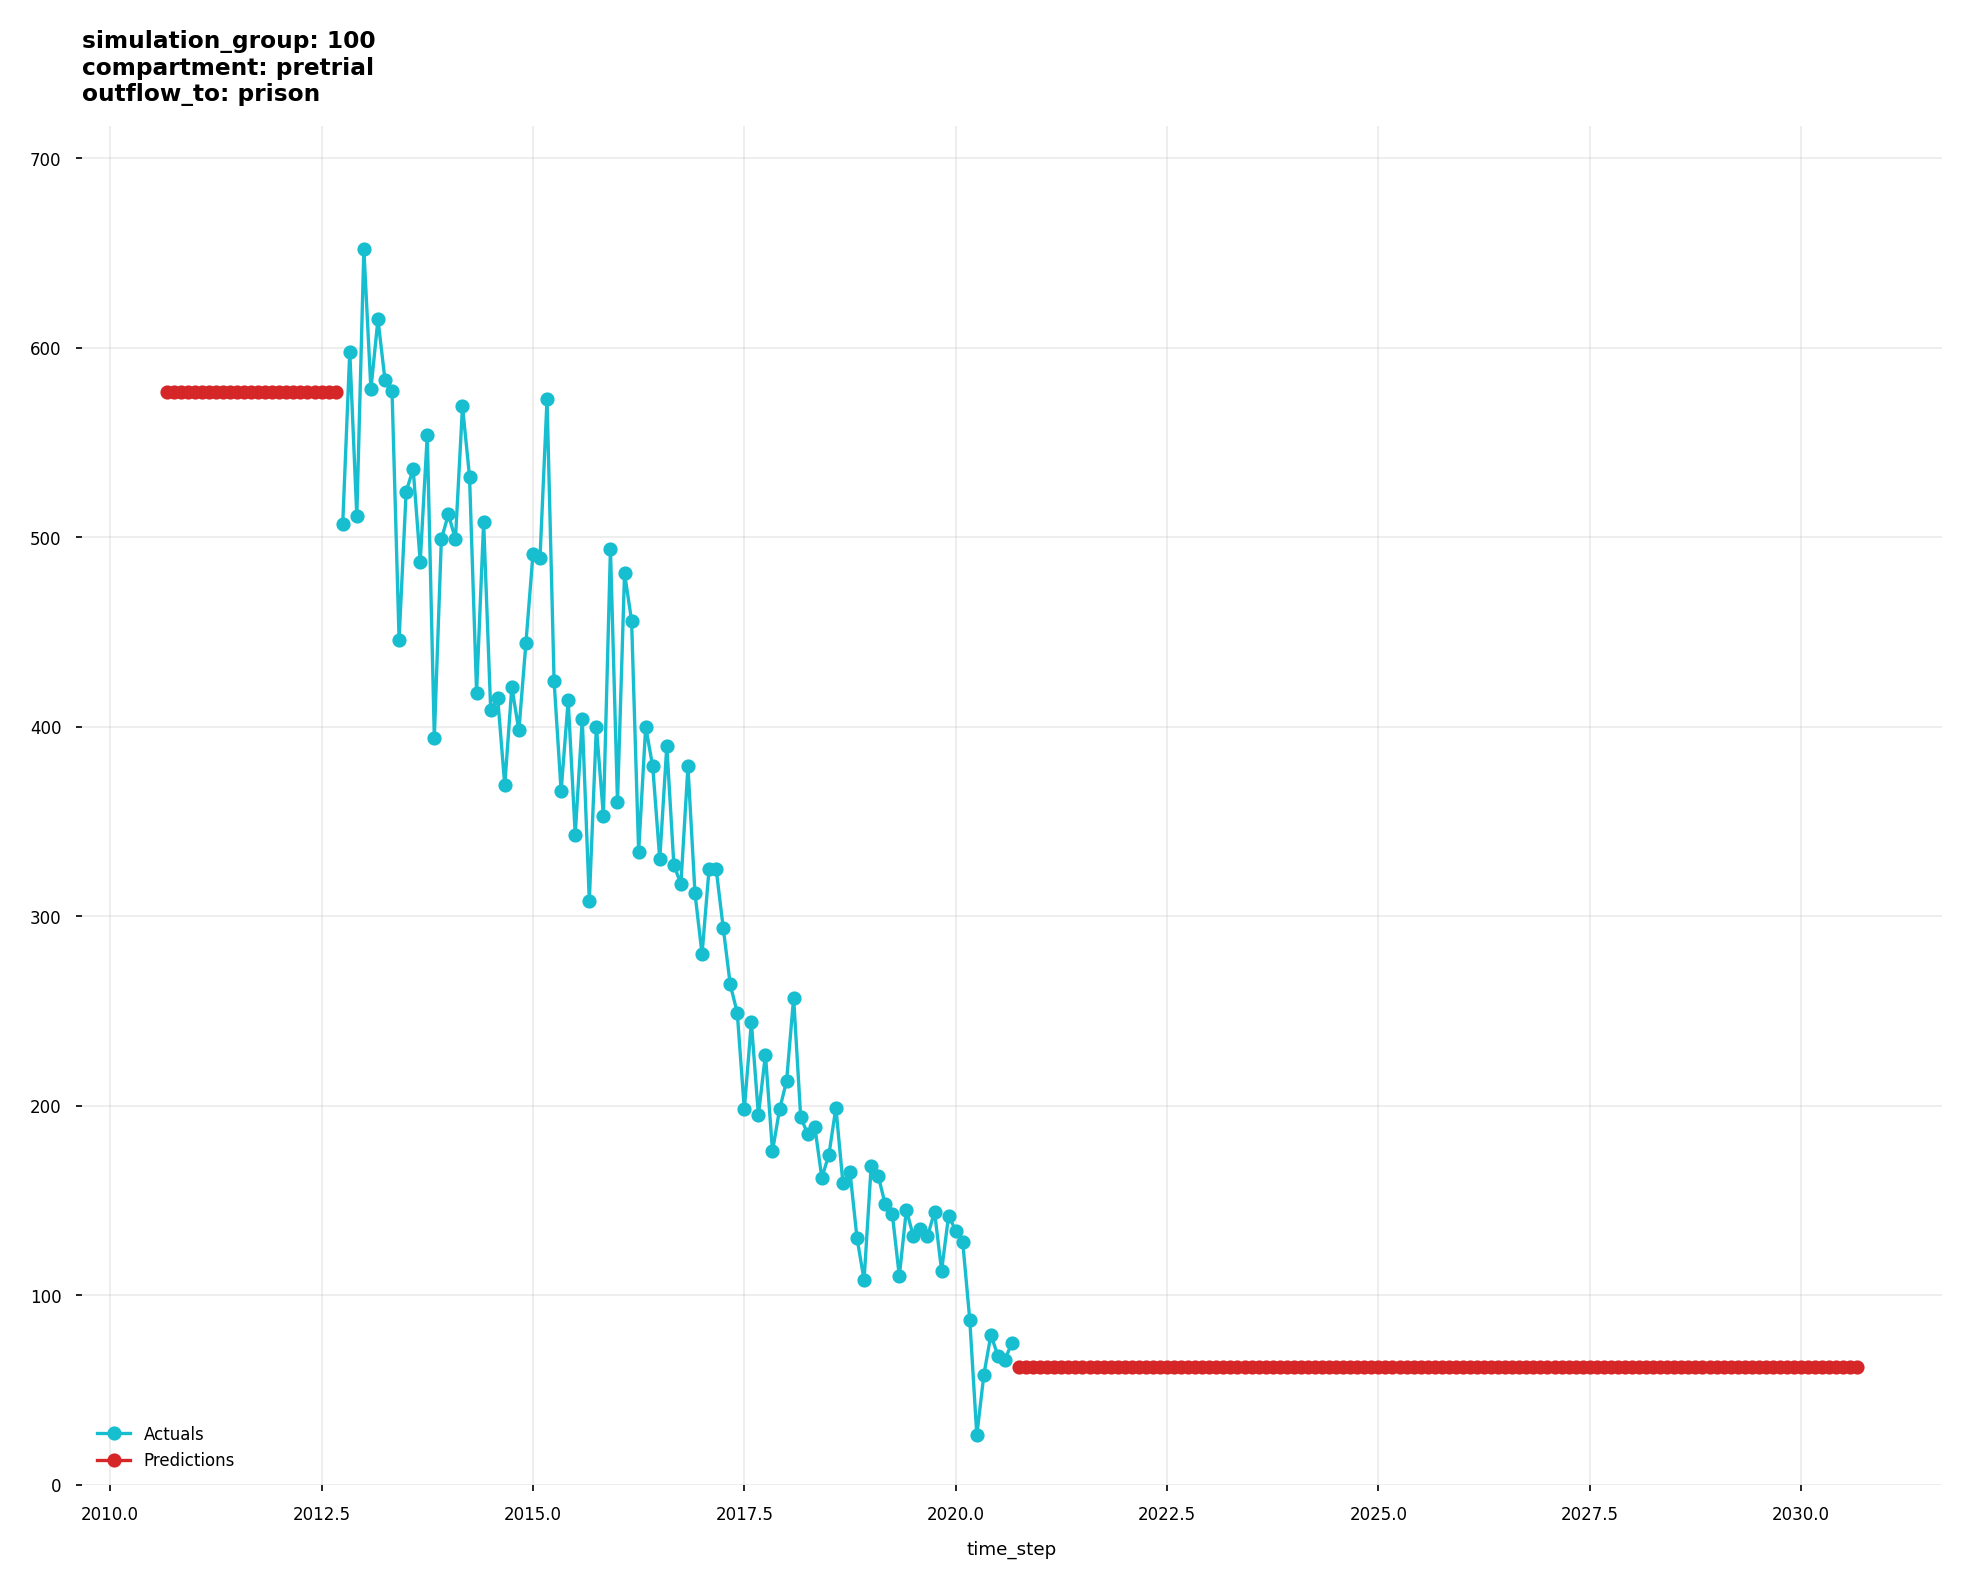

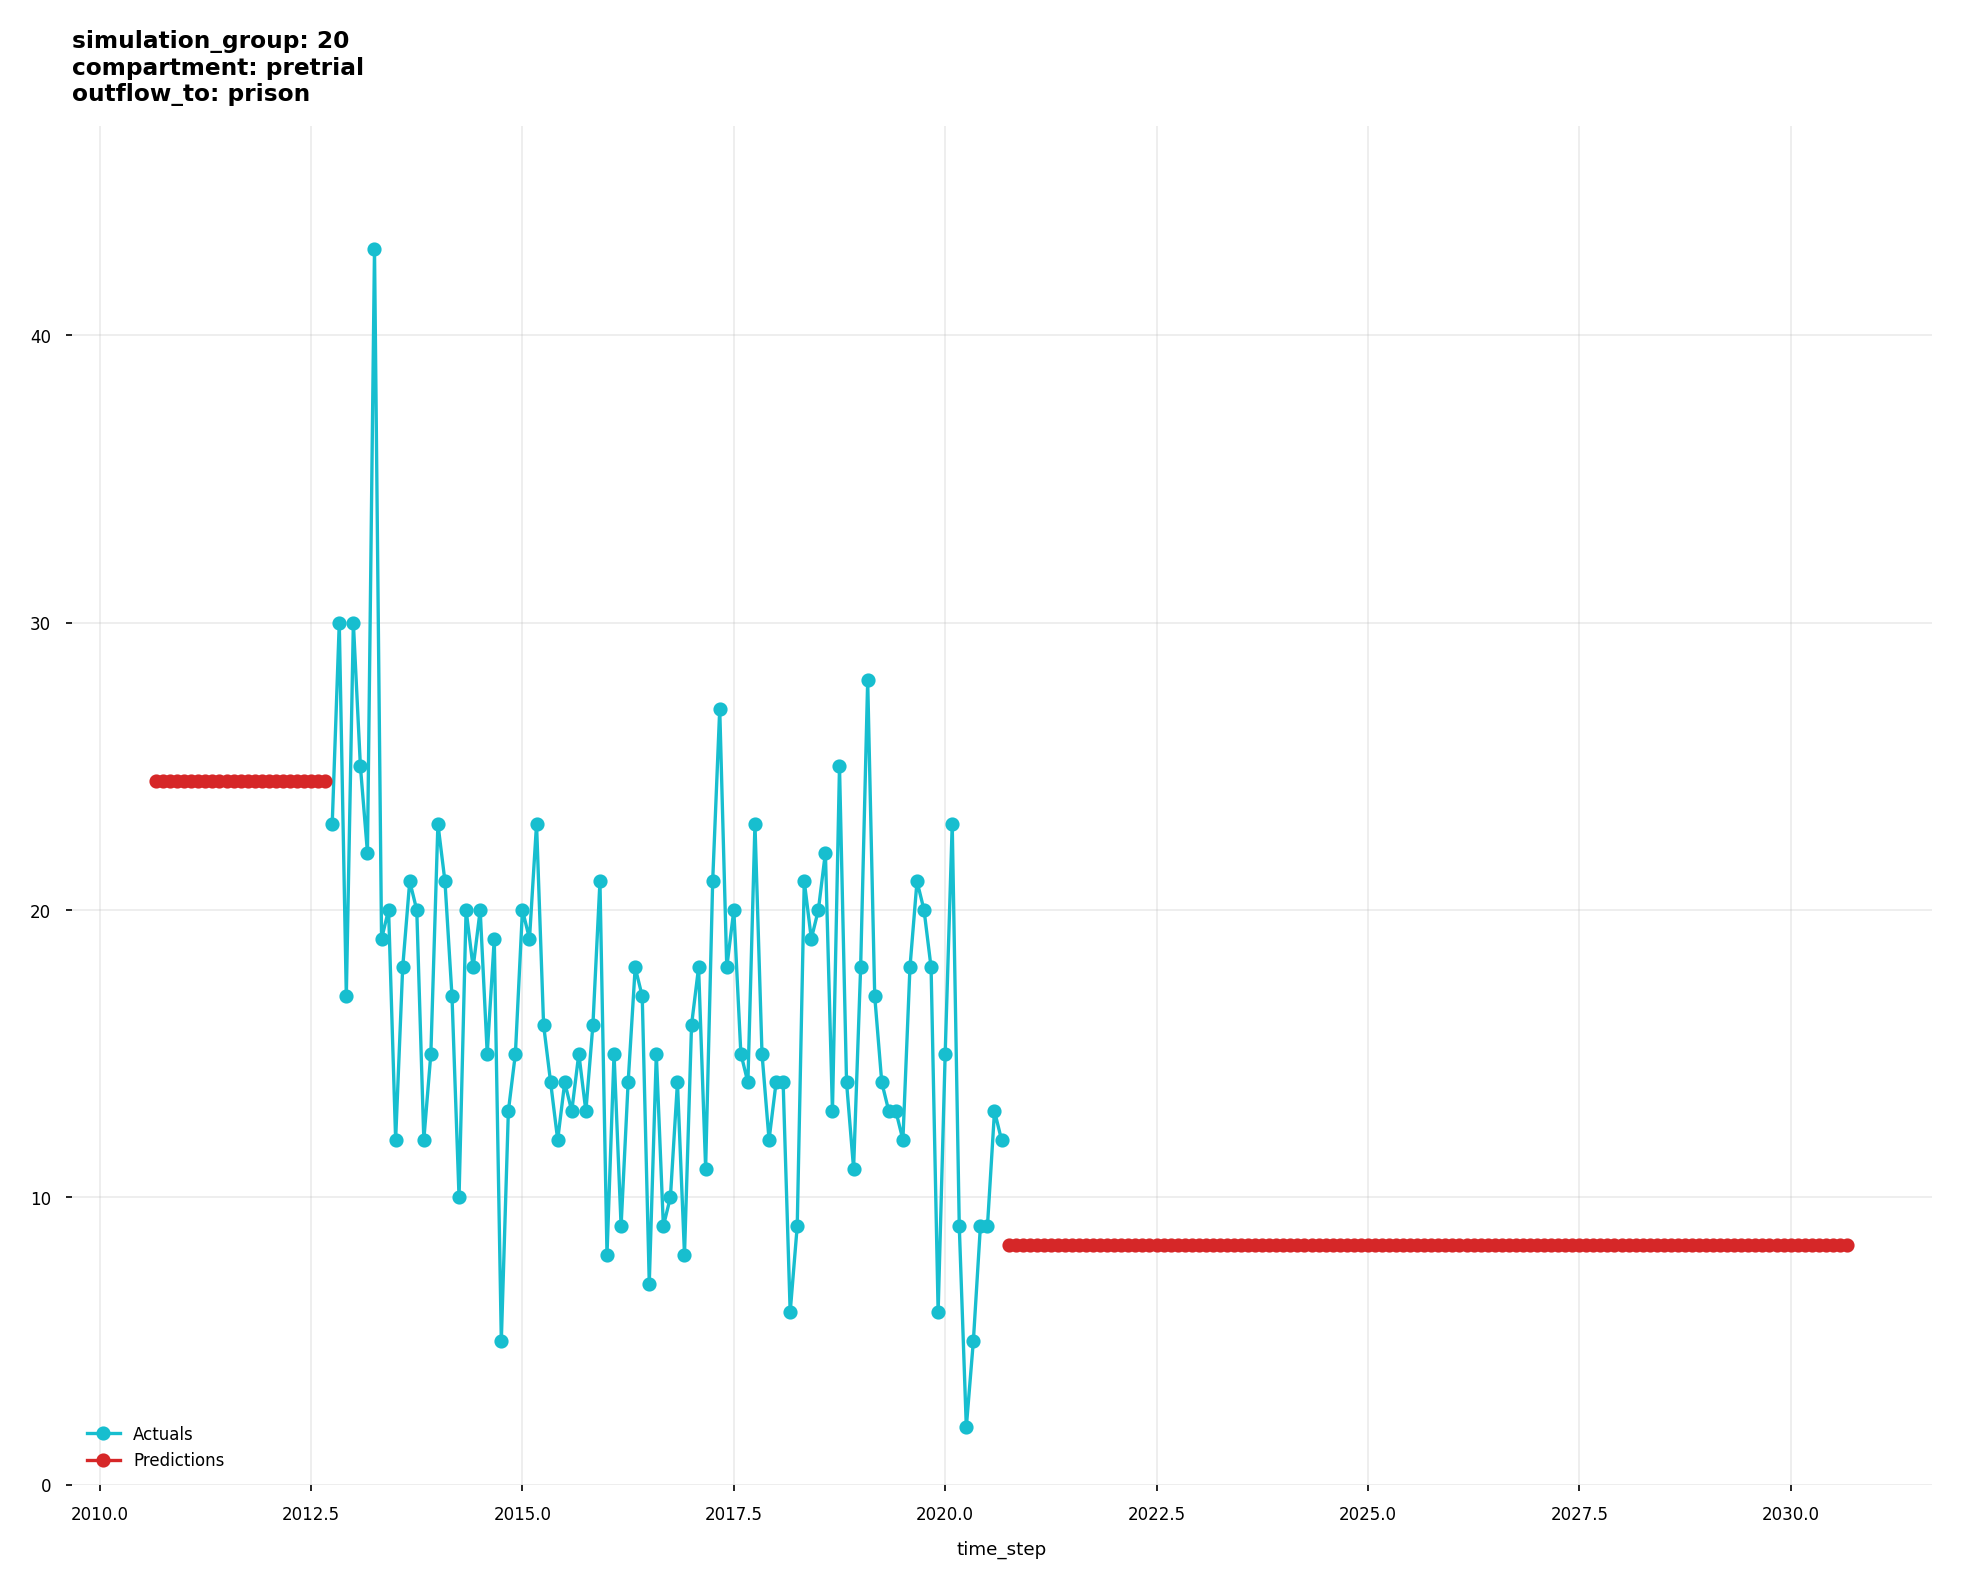

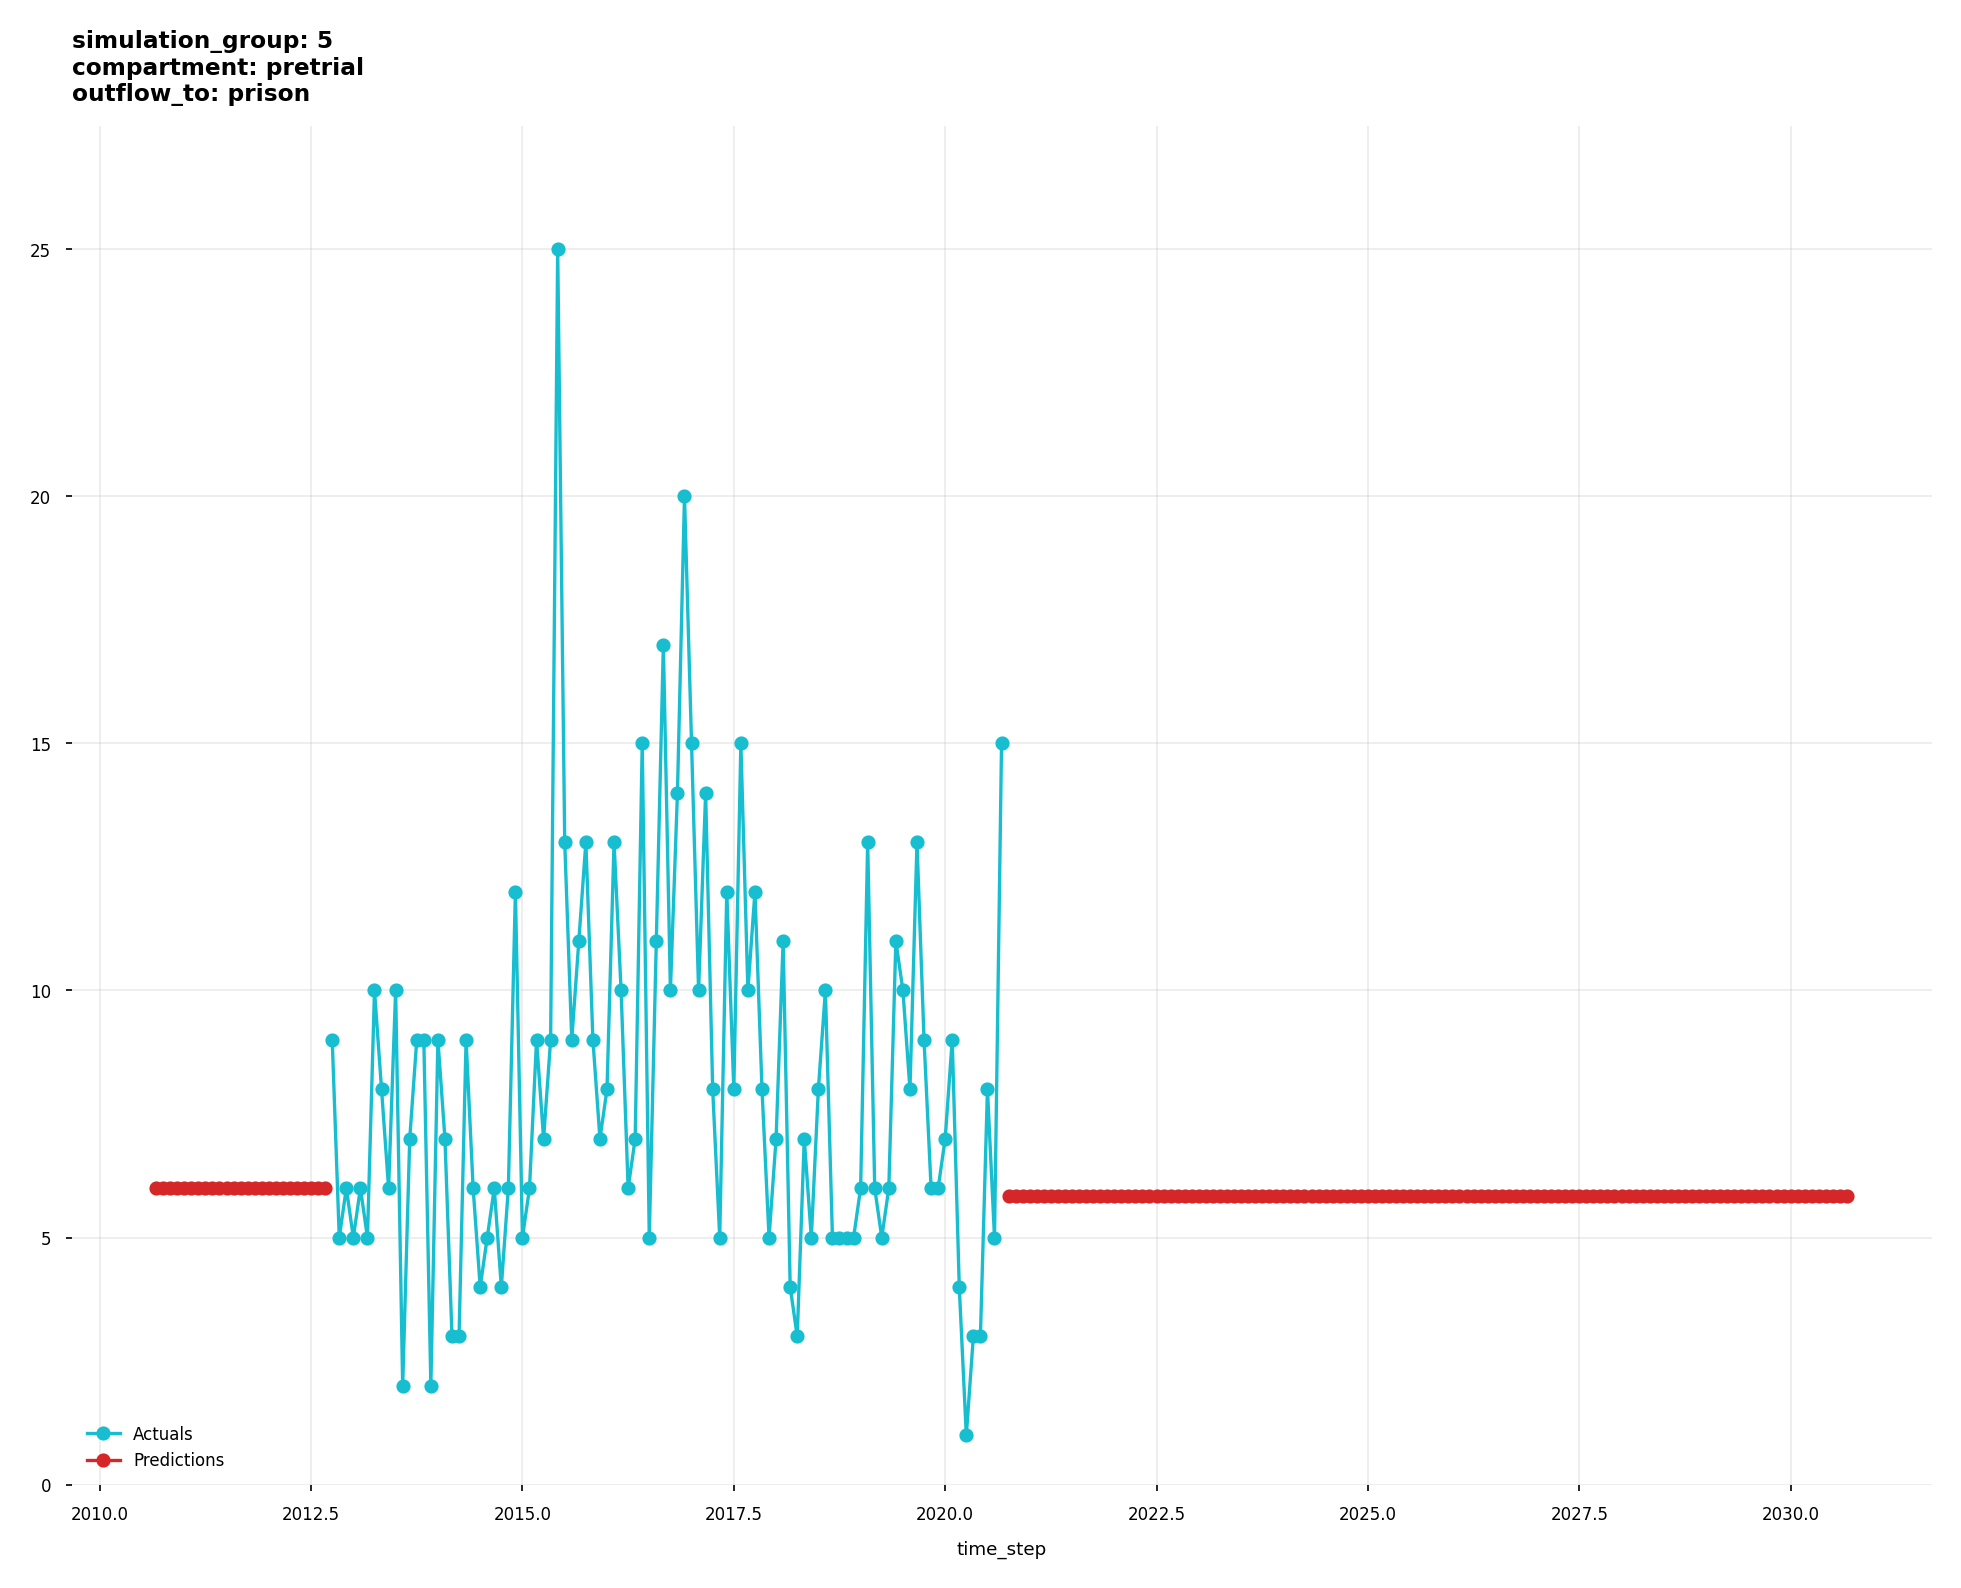

In [125]:
policy_sim.get_arima_output_plots(simulation_title="control", by_simulation_group=True)

[<AxesSubplot:title={'left':'simulation_group: 100\ncompartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>,
 <AxesSubplot:title={'left':'simulation_group: 20\ncompartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>,
 <AxesSubplot:title={'left':'simulation_group: 5\ncompartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>]

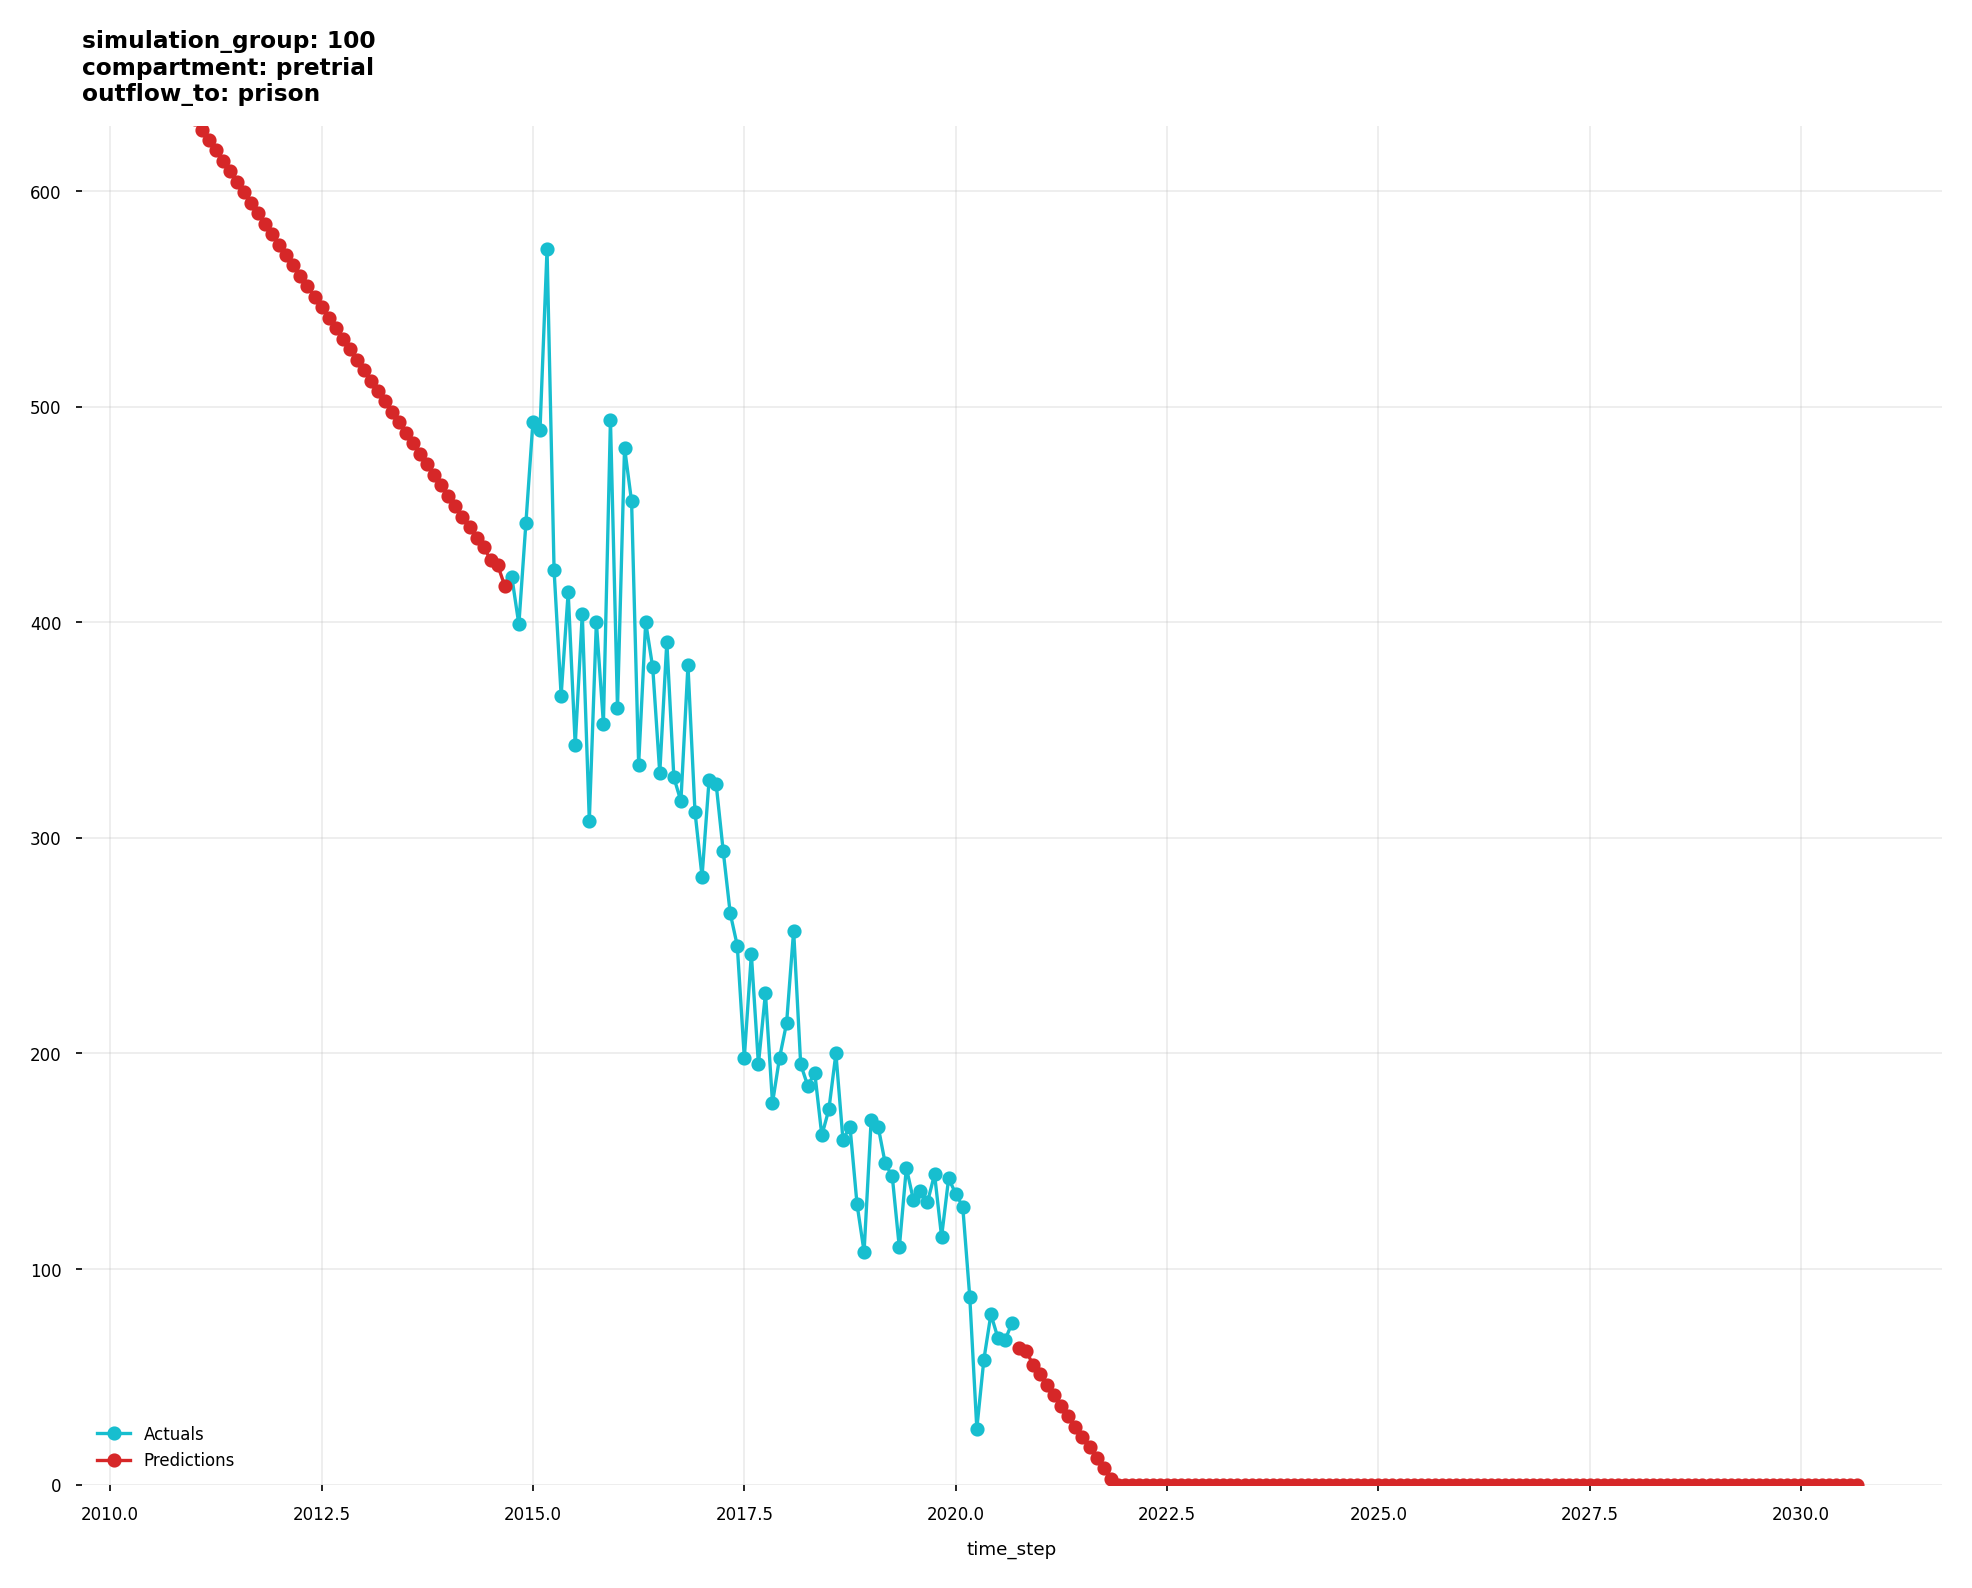

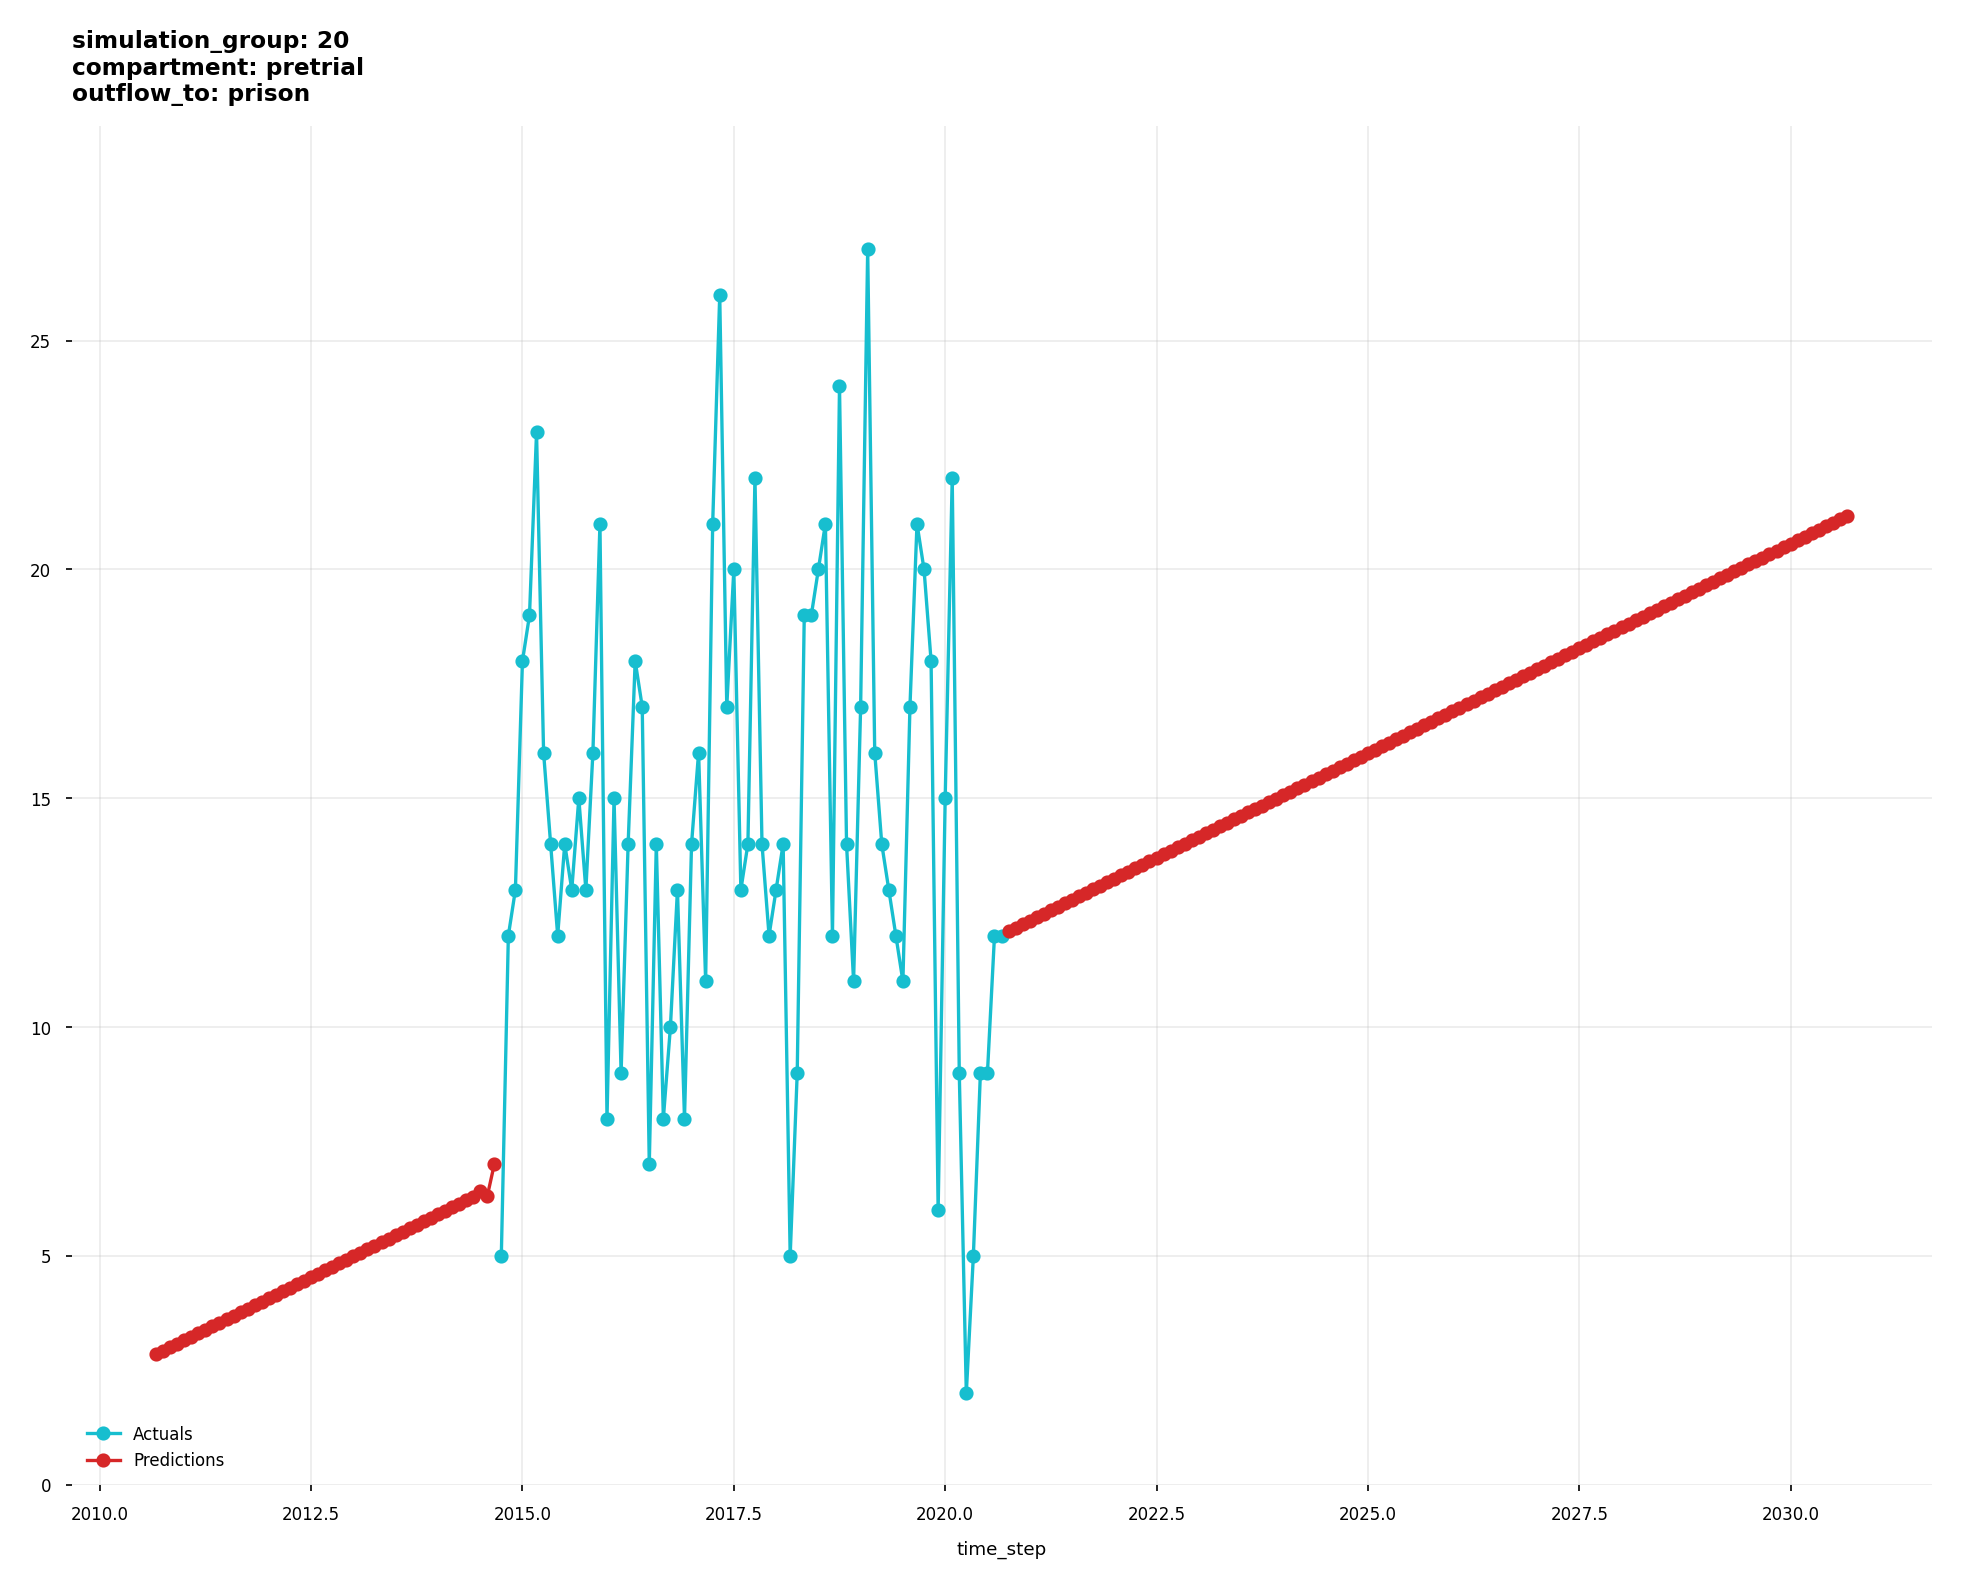

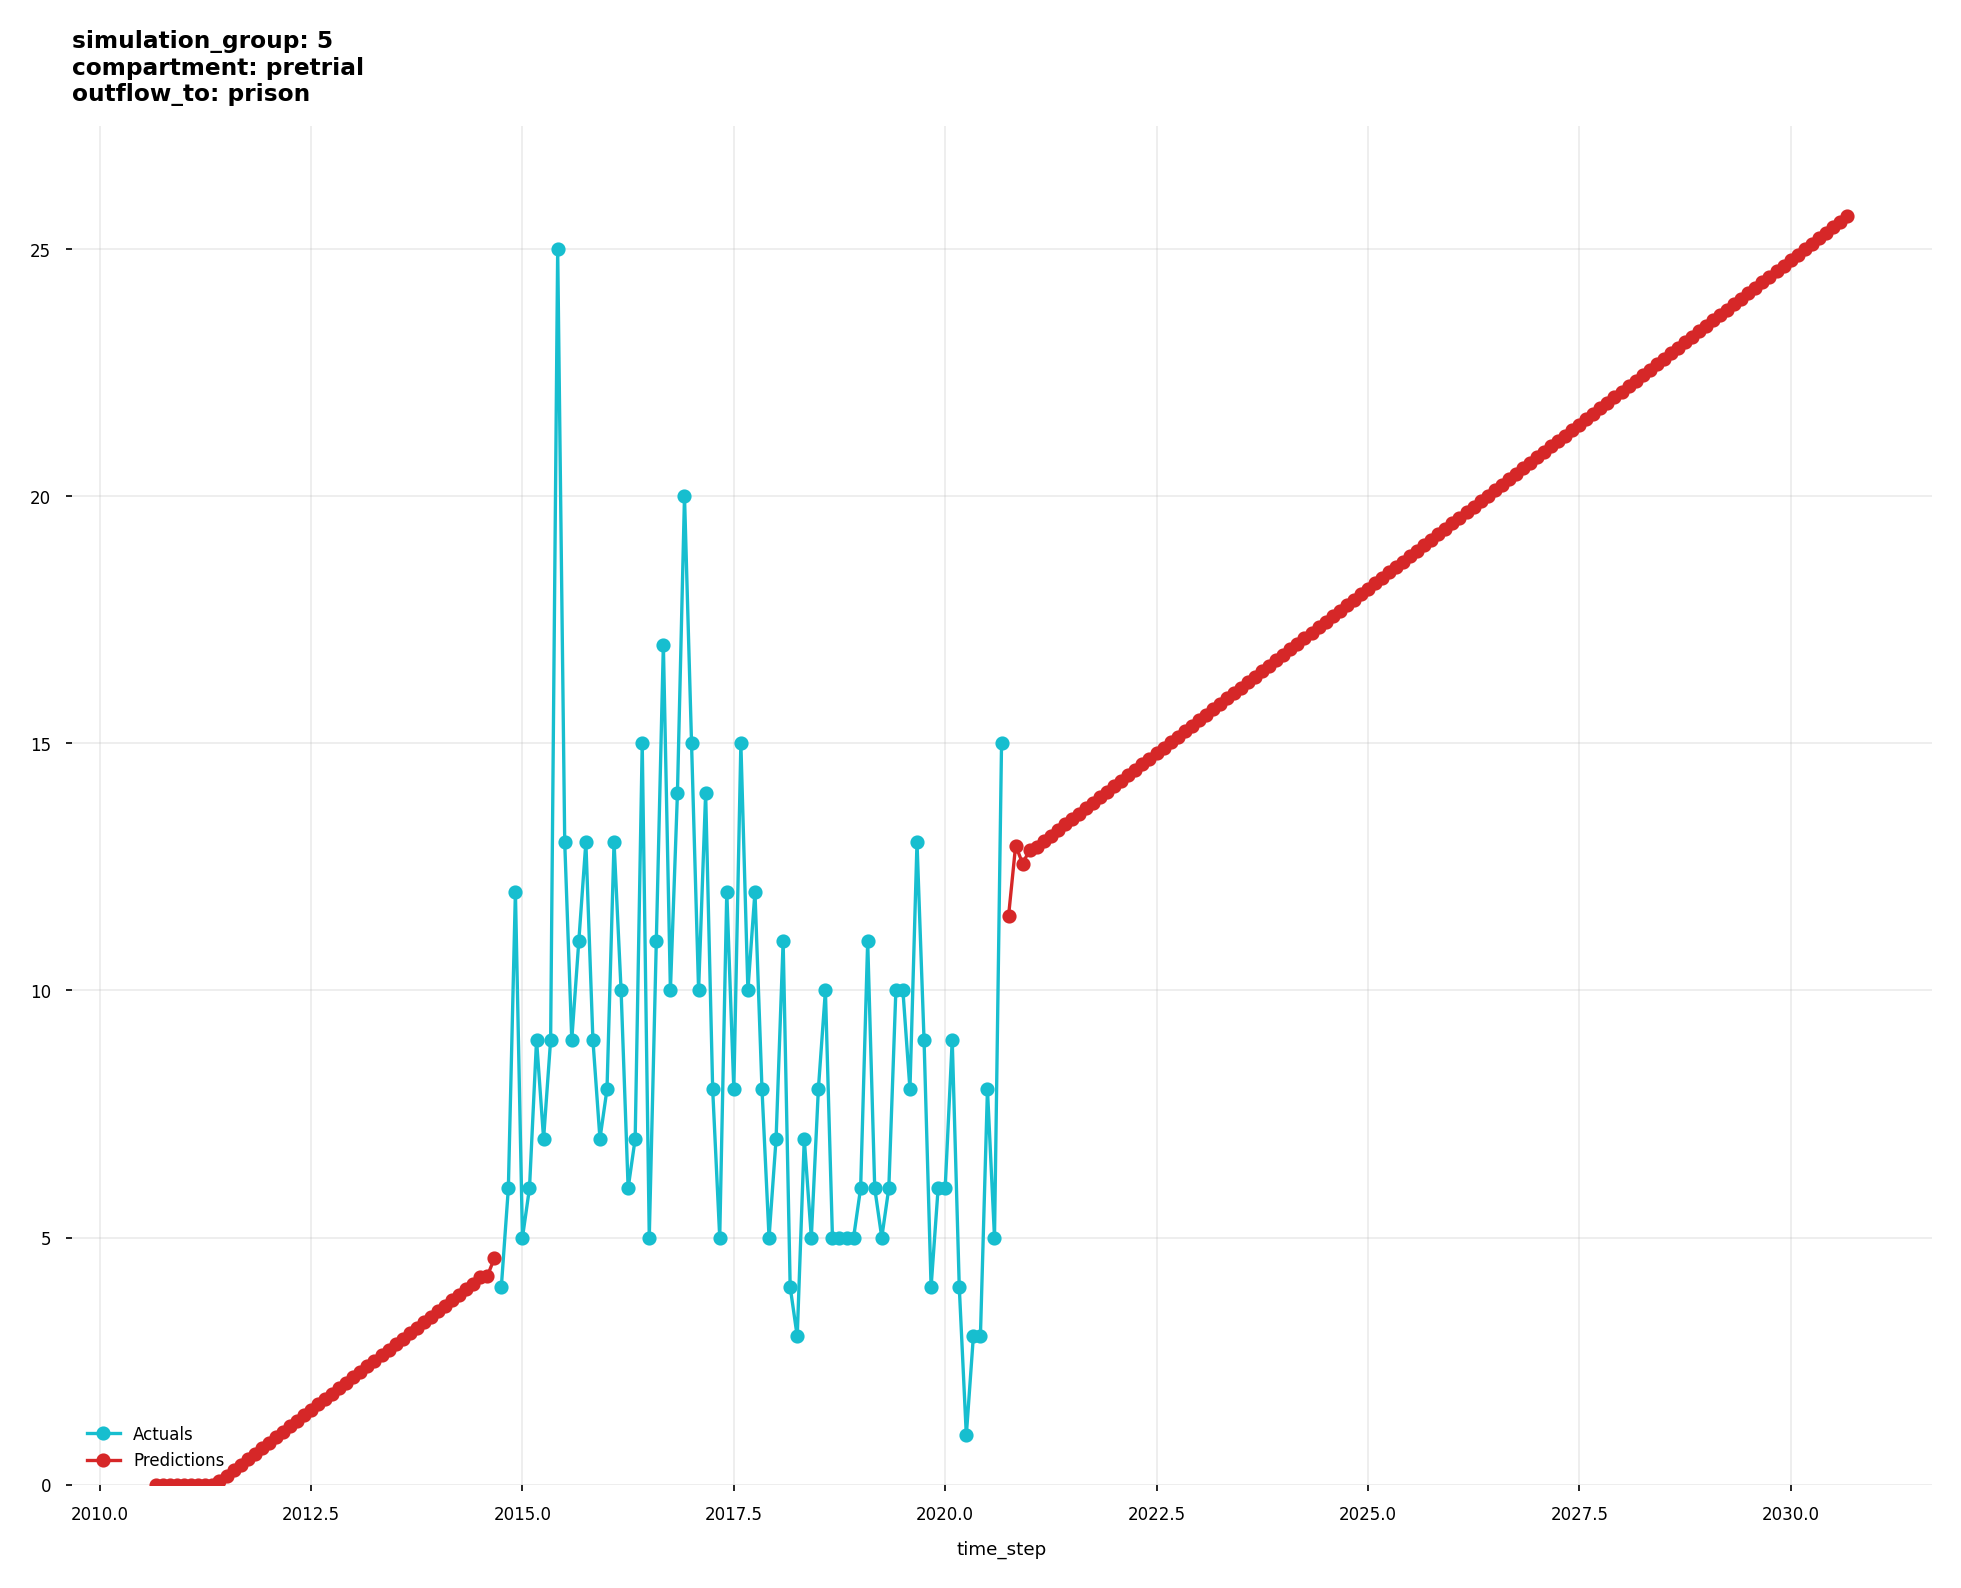

In [71]:
policy_sim.get_arima_output_plots(
    simulation_title="baseline_projections", by_simulation_group=True
)

/Users/justine/.local/share/virtualenvs/pulse-data-xK3VhzVV/lib/python3.8/site-packages/pandas/core/indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value


initialization time:  7.305008888244629
simulation_time:  7.180202960968018


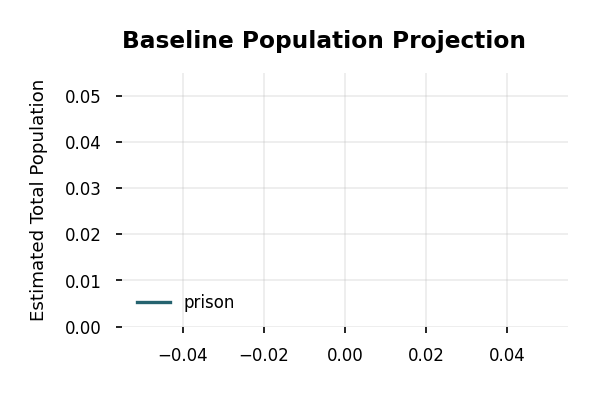

In [91]:
policy_sim.simulate_baseline(["prison"])

/var/folders/0j/xkvk5w791vj4vtys8s77jn4w0000gn/T/ipykernel_52609/1323526667.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  baseline_output.set_index(["compartment", "time_step", "simulation_group"]).loc["prison", "total_population"]\


Text(0.0, 1.0, 'FED HB 5977 Population Projection')

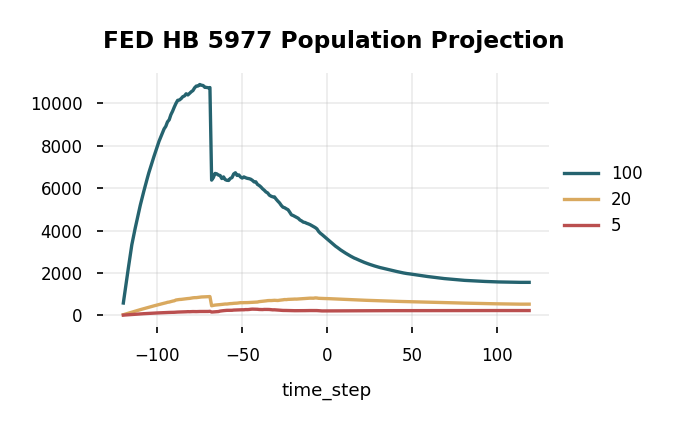

In [124]:
baseline_output = policy_sim.validator.pop_simulations["control"].population_projections
baseline_output.set_index(["compartment", "time_step", "simulation_group"]).loc[
    "prison", "total_population"
].unstack("simulation_group").plot()
add_legend()
plt.title("FED HB 5977 Population Projection")

Text(0.0, 1.0, 'Baseline Simulation Projected Transitions')

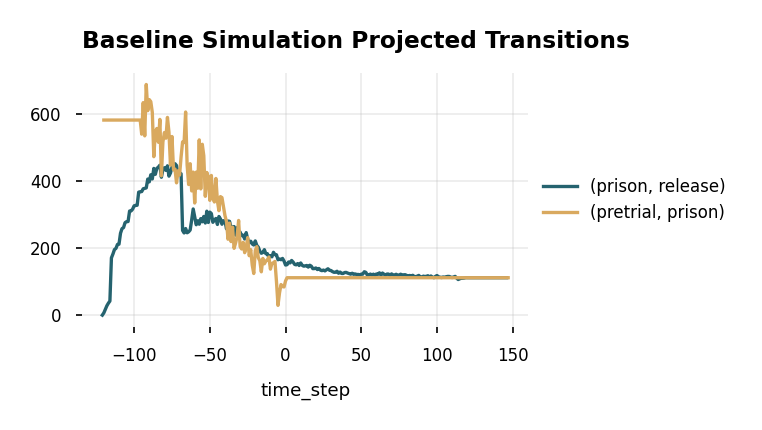

In [21]:
baseline_outflows = (
    policy_sim.validator.pop_simulations["control"].get_outflows().copy()
)
baseline_outflows[
    "year"
] = policy_sim.initializer.time_converter.convert_time_steps_to_year(
    baseline_outflows.index.get_level_values("time_step")
)
baseline_outflows = baseline_outflows[baseline_outflows["compartment"] != "release"]
baseline_outflows.groupby(["time_step", "compartment", "outflow_to"]).sum()[
    "total_population"
].unstack(["compartment", "outflow_to"]).plot()
add_legend()
plt.title("Baseline Simulation Projected Transitions")

Text(0.0, 1.0, 'Policy Simulation Projected Transitions')

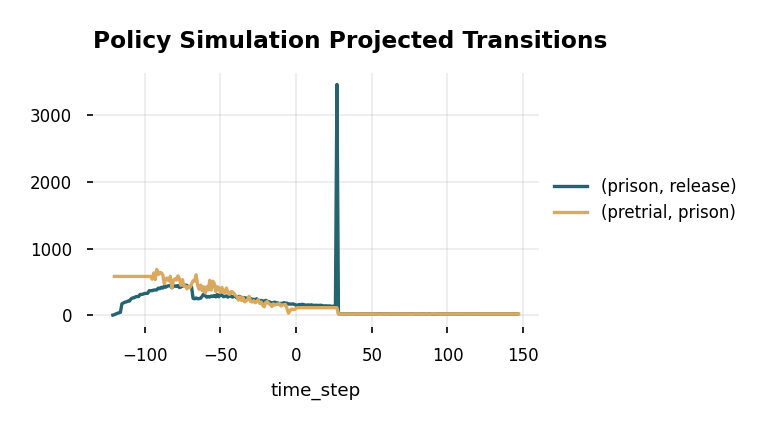

In [22]:
policy_outflows = policy_sim.validator.pop_simulations["policy"].get_outflows().copy()
policy_outflows[
    "year"
] = policy_sim.initializer.time_converter.convert_time_steps_to_year(
    policy_outflows.index.get_level_values("time_step")
)
policy_outflows = policy_outflows[policy_outflows["compartment"] != "release"]
policy_outflows.groupby(["time_step", "compartment", "outflow_to"]).sum()[
    "total_population"
].unstack(["compartment", "outflow_to"]).plot()
add_legend()
plt.title("Policy Simulation Projected Transitions")

In [23]:
policy_outflows[policy_outflows["simulation_group"] == "100"].loc["prison"]

,total_population,compartment,simulation_group,year
time_step,,,,
-120,551.166667,pretrial,100,2010.666667
-119,551.166667,pretrial,100,2010.750000
-118,551.166667,pretrial,100,2010.833333
-117,551.166667,pretrial,100,2010.916667
-116,551.166667,pretrial,100,2011.000000
...,...,...,...,...
143,0.000000,pretrial,100,2032.583333
144,0.000000,pretrial,100,2032.666667
145,0.000000,pretrial,100,2032.750000


In [31]:
outflows_diff = baseline_outflows.reset_index(drop=False).merge(
    policy_outflows.reset_index(drop=False),
    how="inner",
    on=["time_step", "outflow_to", "compartment", "simulation_group", "year"],
    suffixes=("_control", "_policy"),
)
outflows_diff["outflows_difference"] = (
    outflows_diff["total_population_policy"] - outflows_diff["total_population_control"]
)
outflows_diff["actual_year"] = np.floor(outflows_diff["year"])
outflows_diff[
    (outflows_diff["compartment"] == "pretrial") & (outflows_diff["year"] >= 2022)
]

,outflow_to,time_step,total_population_control,compartment,simulation_group,year,total_population_policy,outflows_difference,actual_year
136,prison,16,93.333333,pretrial,100,2022.000000,93.333333,0.0,2022.0
137,prison,17,93.333333,pretrial,100,2022.083333,93.333333,0.0,2022.0
138,prison,18,93.333333,pretrial,100,2022.166667,93.333333,0.0,2022.0
139,prison,19,93.333333,pretrial,100,2022.250000,93.333333,0.0,2022.0
140,prison,20,93.333333,pretrial,100,2022.333333,93.333333,0.0,2022.0
...,...,...,...,...,...,...,...,...,...
1335,prison,143,6.333333,pretrial,5,2032.583333,6.333333,0.0,2032.0
1336,prison,144,6.333333,pretrial,5,2032.666667,6.333333,0.0,2032.0
1337,prison,145,6.333333,pretrial,5,2032.750000,6.333333,0.0,2032.0
1338,prison,146,6.333333,pretrial,5,2032.833333,6.333333,0.0,2032.0


/var/folders/0j/xkvk5w791vj4vtys8s77jn4w0000gn/T/ipykernel_58074/1988763416.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  outflows_diff.set_index(["outflow_to", "year", "simulation_group"]


<AxesSubplot:xlabel='year'>

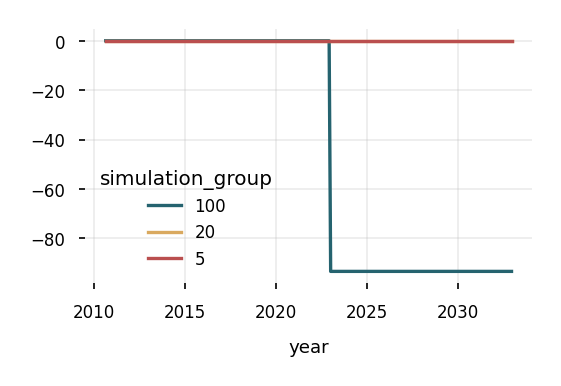

In [25]:
outflows_diff.set_index(["outflow_to", "year", "simulation_group"]).loc[
    "prison", "outflows_difference"
].unstack(["simulation_group"]).plot()

In [30]:
outflows_diff.head()

,outflow_to,time_step,total_population_control,compartment,simulation_group,year,total_population_policy,outflows_difference,actual_year
0,prison,-120,551.166667,pretrial,100,2010.666667,551.166667,0.0,2010.0
1,prison,-119,551.166667,pretrial,100,2010.750000,551.166667,0.0,2010.0
2,prison,-118,551.166667,pretrial,100,2010.833333,551.166667,0.0,2010.0
3,prison,-117,551.166667,pretrial,100,2010.916667,551.166667,0.0,2010.0
4,prison,-116,551.166667,pretrial,100,2011.000000,551.166667,0.0,2011.0


<AxesSubplot:xlabel='year'>

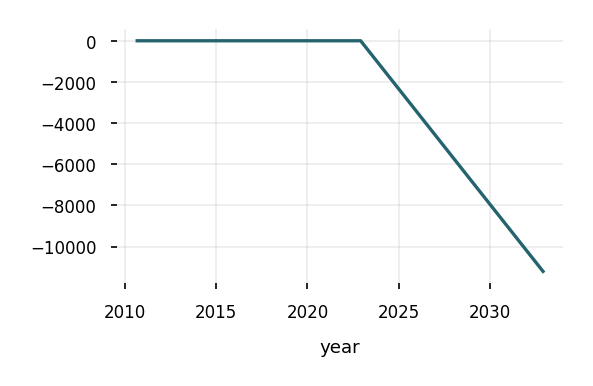

In [26]:
cummulative_outflows_diff = (
    outflows_diff.groupby(["outflow_to", "year"])
    .sum()
    .loc["prison", "outflows_difference"]
    .cumsum()
)
cummulative_outflows_diff.plot()

In [27]:
cummulative_outflows_diff[
    (cummulative_outflows_diff.index.get_level_values("year") % 1) > 0.9
]

year
2010.916667        0.0
2011.916667        0.0
2012.916667        0.0
2013.916667        0.0
2014.916667        0.0
2015.916667        0.0
2016.916667        0.0
2017.916667        0.0
2018.916667        0.0
2019.916667        0.0
2020.916667        0.0
2021.916667        0.0
2022.916667        0.0
2023.916667    -1120.0
2024.916667    -2240.0
2025.916667    -3360.0
2026.916667    -4480.0
2027.916667    -5600.0
2028.916667    -6720.0
2029.916667    -7840.0
2030.916667    -8960.0
2031.916667   -10080.0
2032.916667   -11200.0
Name: outflows_difference, dtype: float64

In [33]:
outflows_diff[outflows_diff["outflow_to"] == "prison"].groupby("actual_year").sum()[
    "outflows_difference"
]

actual_year
2010.0       0.0
2011.0       0.0
2012.0       0.0
2013.0       0.0
2014.0       0.0
2015.0       0.0
2016.0       0.0
2017.0       0.0
2018.0       0.0
2019.0       0.0
2020.0       0.0
2021.0       0.0
2022.0       0.0
2023.0   -1120.0
2024.0   -1120.0
2025.0   -1120.0
2026.0   -1120.0
2027.0   -1120.0
2028.0   -1120.0
2029.0   -1120.0
2030.0   -1120.0
2031.0   -1120.0
2032.0   -1120.0
Name: outflows_difference, dtype: float64

In [127]:
%%bigquery transitions_df
WITH latest_runs AS
(
SELECT simulation_tag, MAX(date_created) as latest_run
FROM `recidiviz-staging.spark_public_input_data.transitions_data_raw`
GROUP BY simulation_tag
)
SELECT data.*
FROM `recidiviz-staging.spark_public_input_data.transitions_data_raw` data
LEFT JOIN latest_runs ON data.simulation_tag = latest_runs.simulation_tag
WHERE data.simulation_tag = 'fed_h5977'
    AND date_created = latest_runs.latest_run
ORDER BY compartment, compartment_duration

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 305/305 [00:01<00:00, 210.57rows/s]


<AxesSubplot:xlabel='compartment_duration'>

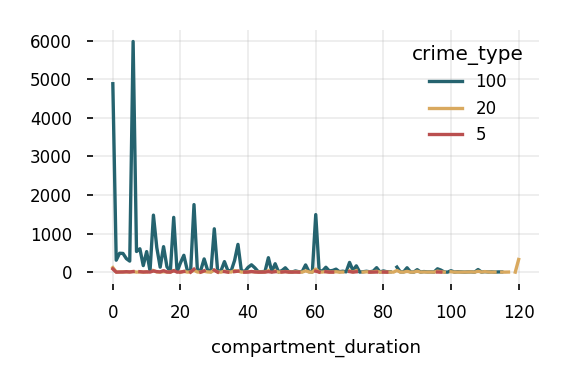

In [128]:
transitions_df.set_index(["compartment", "crime_type", "compartment_duration"]).loc[
    "prison"
].unstack("crime_type")["total_population"].plot()

In [22]:
transitions_df.set_index(["compartment", "crime_type", "compartment_duration"]).loc[
    "prison", "5"
]

/var/folders/0j/xkvk5w791vj4vtys8s77jn4w0000gn/T/ipykernel_50343/4077636974.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  transitions_df.set_index(["compartment", "crime_type", "compartment_duration"]


,simulation_tag,outflow_to,total_population,crime,age,race,date_created
compartment_duration,,,,,,,
0.0,fed_h5977,release,75.0,None,None,None,2021-11-18 15:59:00.624130+00:00
1.0,fed_h5977,release,1.0,None,None,None,2021-11-18 15:59:00.624130+00:00
2.0,fed_h5977,release,3.0,None,None,None,2021-11-18 15:59:00.624130+00:00
3.0,fed_h5977,release,3.0,None,None,None,2021-11-18 15:59:00.624130+00:00
4.0,fed_h5977,release,12.0,None,None,None,2021-11-18 15:59:00.624130+00:00
5.0,fed_h5977,release,4.0,None,None,None,2021-11-18 15:59:00.624130+00:00
6.0,fed_h5977,release,11.0,None,None,None,2021-11-18 15:59:00.624130+00:00
8.0,fed_h5977,release,12.0,None,None,None,2021-11-18 15:59:00.624130+00:00
9.0,fed_h5977,release,4.0,None,None,None,2021-11-18 15:59:00.624130+00:00


In [134]:
%%bigquery population_df
WITH latest_runs AS
(
SELECT simulation_tag, MAX(date_created) as latest_run
FROM `recidiviz-staging.spark_public_input_data.total_population_data_raw`
GROUP BY simulation_tag
)
SELECT data.*
FROM `recidiviz-staging.spark_public_input_data.total_population_data_raw` data
LEFT JOIN latest_runs ON data.simulation_tag = latest_runs.simulation_tag
WHERE data.simulation_tag = 'fed_h5977'
    AND date_created = latest_runs.latest_run
ORDER BY time_step

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 207/207 [00:01<00:00, 138.26rows/s]


In [135]:
population_df[
    "year"
] = policy_sim.initializer.time_converter.convert_time_steps_to_year(
    population_df["time_step"]
)

<AxesSubplot:xlabel='year'>

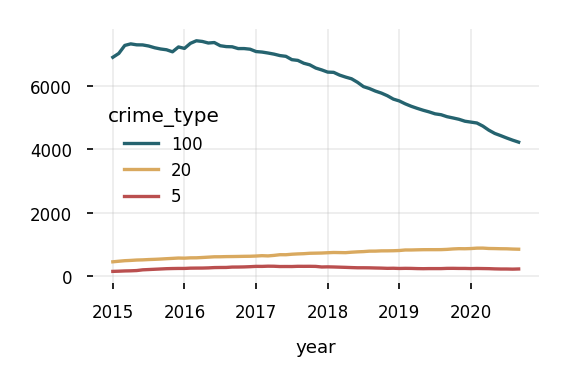

In [136]:
population_df.set_index(["compartment", "year", "crime_type"]).loc["prison"].unstack(
    "crime_type"
)["total_population"].plot()

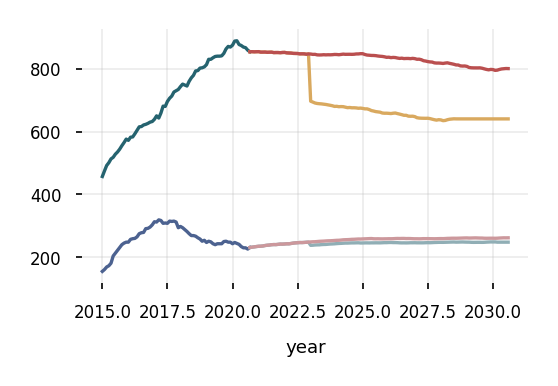

In [141]:
for crime_type in ["20", "5"]:
    ax = (
        population_df[population_df["crime_type"] == crime_type]
        .set_index(["compartment", "year"])
        .loc["prison", "total_population"]
        .plot()
    )

    policy_results[policy_results["simulation_group"] == crime_type].groupby(
        ["compartment", "year"]
    ).sum().loc["prison", ["policy_total_population", "control_total_population"]].plot(
        ax=ax
    )
plt.legend().remove()

In [170]:
policy_results.tail()

,compartment,year,policy_total_population,simulation_group,control_total_population,population_difference
715,release,2030.250000,1245.795580,5,1232.633632,13.161947
716,release,2030.333333,1252.128918,5,1238.627747,13.501171
717,release,2030.416667,1258.462257,5,1244.626906,13.835352
718,release,2030.500000,1264.795597,5,1251.085304,13.710293
719,release,2030.583333,1271.128936,5,1257.275110,13.853826
